In [2]:
from numpy.random import seed
seed(101)
import tensorflow as tf
tf.random.set_seed(101) 

import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [94]:
os.listdir('archive/')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [95]:
base_dir = 'base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)


val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



In [13]:
df_data = pd.read_csv(r'C:\Users\tonyt\archive\HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [14]:
df = df_data.groupby('lesion_id').count()

df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [15]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [16]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [17]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [18]:
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [19]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [20]:
def identify_val_rows(x):
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_data['train_or_val'] = df_data['image_id']
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [21]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [22]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [106]:
df_data.set_index('image_id', inplace=True)

In [107]:
folder_1 = os.listdir(r'C:\Users\tonyt\archive\ham10000_images_part_1')
folder_2 = os.listdir(r'C:\Users\tonyt\archive\ham10000_images_part_2')

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join(r'C:\Users\tonyt\archive\ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(r'C:\Users\tonyt\archive\ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)


for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join(r'C:\Users\tonyt\archive\ham10000_images_part_1', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(r'C:\Users\tonyt\archive\ham10000_images_part_2', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)
        

In [108]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [109]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [110]:
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    img_list = os.listdir('base_dir/train_dir/' + img_class)

    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)

    
    num_aug_images_wanted = 6000 
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [111]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [112]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


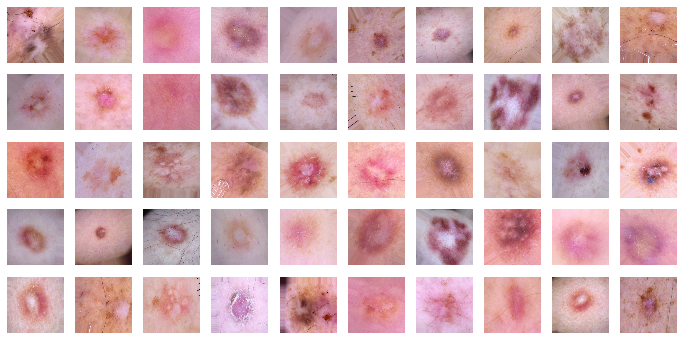

In [113]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None)

In [23]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [24]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.efficientnet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [6]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [4]:
height=224  # image height
width=224   # image width
channels=3
img_shape=(height, width, channels)

In [7]:
model_name='EfficientNetB4'
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=tensorflow.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),activity_regularizer=tf.keras.regularizers.l1(0.006),
                bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(7, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(tf.keras.optimizers.Adamax(learning_rate=.001), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy]) 

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 112, 112, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_d

 block2c_expand_activation (Act  (None, 56, 56, 192)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 192)  0          ['block2c_bn[0][0]']             
 )        

                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 28, 28, 192)  4800       ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 28, 28, 192)  768        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 28, 28, 192)  0          ['block3a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3a_s

 block3c_se_squeeze (GlobalAver  (None, 336)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block3c_se_reduce[0][0]']      
                                                                                                  
 block3c_se_excite (Multiply)   (None, 28, 28, 336)  0           ['block3c_activation[0][0]',     
          

                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 14, 14, 336)  0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_p

 block4c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 112)  0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 14, 14, 112)  0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_e

 block4e_drop (Dropout)         (None, 14, 14, 112)  0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 14, 14, 112)  0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block4e_add[0][0]']            
                                                                                                  
 block4f_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block4f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4f_e

 block5b_expand_activation (Act  (None, 14, 14, 960)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 14, 14, 960)  24000      ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 960)  0          ['block5b_bn[0][0]']             
 )        

                                                                                                  
 block5d_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 960)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 960)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_s

 )                                                                                                
                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 960)         0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5f_se_reshape[0][0]']     
                                                                                                  
 block5f_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5f_se_reduce[0][0]']      
          

 block6b_se_reduce (Conv2D)     (None, 1, 1, 68)     111044      ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 7, 7, 1632)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6b_project_conv[0][0]']   
 lization)

                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 7, 7, 272)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 7, 7, 272)    0           ['block6d_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 7, 7, 272)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 7, 7, 272)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block6g_expand_conv[0][0]']    
 ization) 

                                                                  'block6g_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6h_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1632)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_d

 batch_normalization_1 (BatchNo  (None, 1792)        7168        ['max_pool[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 dense_2 (Dense)                (None, 256)          459008      ['batch_normalization_1[0][0]']  
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 7)            1799        ['dropout_1[0][0]']              
                                                                                                  
Total params: 18,141,798
Trainable params: 18,013,007
Non-trainable params: 128,791
_________________________

In [277]:
class_weights={
    0: 1.0, 
    1: 1.0, 
    2: 1.0, 
    3: 1.0, 
    4: 2.0, 
    5: 1.0, 
    6: 1.0, 
}

In [280]:
filepath = "modeltensorefficentb4.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=128, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=50, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 3.6418 - categorical_accuracy: 0.7148 - top_2_accuracy: 0.8875 - top_3_accuracy: 0.9523
Epoch 1: val_top_3_accuracy improved from -inf to 0.97868, saving model to modeltensorefficentb4.h5
128/128 [==============================] - 55s 431ms/step - loss: 3.6418 - categorical_accuracy: 0.7148 - top_2_accuracy: 0.8875 - top_3_accuracy: 0.9523 - val_loss: 3.0377 - val_categorical_accuracy: 0.8753 - val_top_2_accuracy: 0.9616 - val_top_3_accuracy: 0.9787 - lr: 0.0010
Epoch 2/50
128/128 [==============================] - ETA: 0s - loss: 3.2805 - categorical_accuracy: 0.7367 - top_2_accuracy: 0.9023 - top_3_accuracy: 0.9664
Epoch 2: val_top_3_accuracy improved from 0.97868 to 0.98081, saving model to modeltensorefficentb4.h5
128/128 [==============================] - 55s 432ms/step - loss: 3.2805 - categorical_accuracy: 0.7367 - top_2_accuracy: 0.9023 - top_3_accuracy: 0.9664 - val_loss: 2.7877 - val_categorical_accuracy: 0

128/128 [==============================] - 55s 430ms/step - loss: 1.6219 - categorical_accuracy: 0.8531 - top_2_accuracy: 0.9555 - top_3_accuracy: 0.9883 - val_loss: 1.3717 - val_categorical_accuracy: 0.9275 - val_top_2_accuracy: 0.9733 - val_top_3_accuracy: 0.9883 - lr: 1.2500e-04
Epoch 17/50
128/128 [==============================] - ETA: 0s - loss: 1.6282 - categorical_accuracy: 0.8531 - top_2_accuracy: 0.9586 - top_3_accuracy: 0.9891
Epoch 17: val_top_3_accuracy did not improve from 0.98934
128/128 [==============================] - 54s 424ms/step - loss: 1.6282 - categorical_accuracy: 0.8531 - top_2_accuracy: 0.9586 - top_3_accuracy: 0.9891 - val_loss: 1.3576 - val_categorical_accuracy: 0.9275 - val_top_2_accuracy: 0.9744 - val_top_3_accuracy: 0.9861 - lr: 6.2500e-05
Epoch 18/50
128/128 [==============================] - ETA: 0s - loss: 1.5564 - categorical_accuracy: 0.8750 - top_2_accuracy: 0.9617 - top_3_accuracy: 0.9836
Epoch 18: val_top_3_accuracy did not improve from 0.98934


128/128 [==============================] - ETA: 0s - loss: 1.5071 - categorical_accuracy: 0.8711 - top_2_accuracy: 0.9578 - top_3_accuracy: 0.9883
Epoch 48: val_top_3_accuracy did not improve from 0.99147
128/128 [==============================] - 58s 452ms/step - loss: 1.5071 - categorical_accuracy: 0.8711 - top_2_accuracy: 0.9578 - top_3_accuracy: 0.9883 - val_loss: 1.2853 - val_categorical_accuracy: 0.9318 - val_top_2_accuracy: 0.9744 - val_top_3_accuracy: 0.9904 - lr: 1.0000e-05
Epoch 49/50
128/128 [==============================] - ETA: 0s - loss: 1.4940 - categorical_accuracy: 0.8734 - top_2_accuracy: 0.9648 - top_3_accuracy: 0.9898
Epoch 49: val_top_3_accuracy did not improve from 0.99147
128/128 [==============================] - 58s 452ms/step - loss: 1.4940 - categorical_accuracy: 0.8734 - top_2_accuracy: 0.9648 - top_3_accuracy: 0.9898 - val_loss: 1.2843 - val_categorical_accuracy: 0.9339 - val_top_2_accuracy: 0.9733 - val_top_3_accuracy: 0.9893 - lr: 1.0000e-05
Epoch 50/50


### Evaluate the model using the val set

In [281]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [282]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

C:\Users\tonyt\AppData\Local\Temp\ipykernel_21928\156468241.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 1.2850333452224731
val_cat_acc: 0.9328358173370361
val_top_2_acc: 0.9744136333465576
val_top_3_acc: 0.9904051423072815


In [25]:
model.load_weights('modeltensorefficentb4.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

C:\Users\tonyt\AppData\Local\Temp\ipykernel_19240\2151566359.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 1.2907569408416748
val_cat_acc: 0.9339019060134888
val_top_2_acc: 0.9744136333465576
val_top_3_acc: 0.9914712309837341


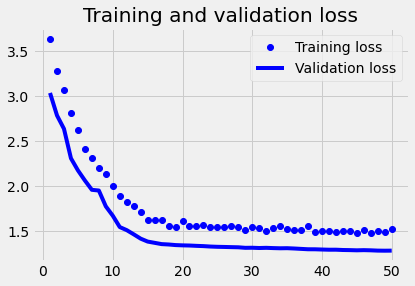

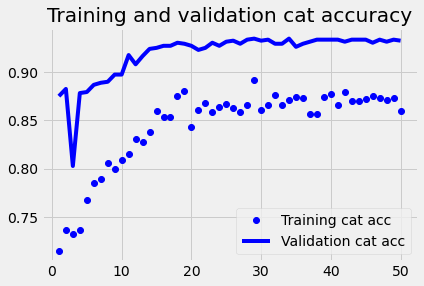

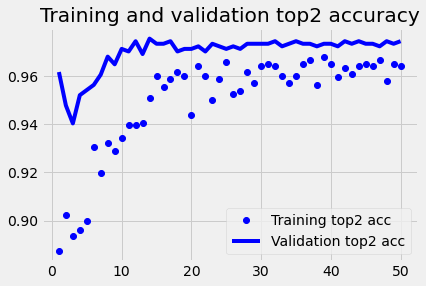

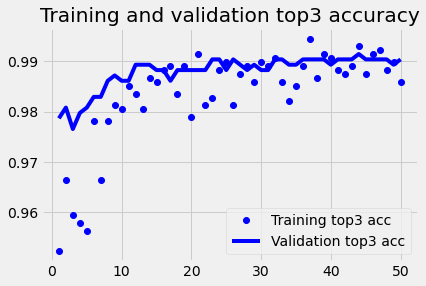

In [284]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [285]:
test_labels = test_batches.classes

In [286]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [287]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [288]:
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

938/938 [==============================] - 33s 32ms/step


In [289]:
predictions.shape

(938, 7)

In [290]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [291]:
test_labels.shape

(938,)

In [292]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [293]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 19   2   1   0   1   3   0]
 [  0  27   2   0   1   0   0]
 [  1   3  53   0   8  10   0]
 [  1   0   0   2   0   3   0]
 [  0   1   2   0  28   8   0]
 [  0   2   8   0   3 737   1]
 [  0   0   0   0   0   1  10]]


C:\Users\tonyt\AppData\Local\Temp\ipykernel_21928\3577836269.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


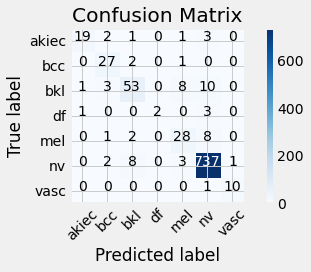

In [294]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [295]:
y_pred = np.argmax(predictions, axis=1)

y_true = test_batches.classes

In [296]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.90      0.73      0.81        26
         bcc       0.77      0.90      0.83        30
         bkl       0.80      0.71      0.75        75
          df       1.00      0.33      0.50         6
         mel       0.68      0.72      0.70        39
          nv       0.97      0.98      0.97       751
        vasc       0.91      0.91      0.91        11

    accuracy                           0.93       938
   macro avg       0.86      0.75      0.78       938
weighted avg       0.93      0.93      0.93       938



In [26]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.efficientnet.preprocess_input(image)
  image = image[None, ...]
  return image

1/1 [==============================] - 0s 33ms/step


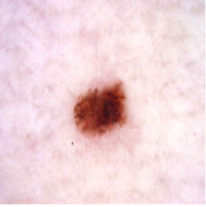

In [50]:
from PIL import Image

image2 = Image.open(r'C:\Users\tonyt\OneDrive\Desktop\images\mel4.png')

image = preprocess(image2)
image_probs = model.predict(image)
image2

In [51]:
image_probs

array([[0.04141545, 0.0393749 , 0.04981925, 0.04391909, 0.480215  ,
        0.2086268 , 0.13662954]], dtype=float32)